<a href="https://colab.research.google.com/github/TruscaPetre/AAIT-Nosy-Missing-Labels/blob/main/tutorial%20colab%20noisy%20labels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noisy labels problem


## Introduction theory

Before starting to implement anything we should think about the problem first. We don't know which of the training samples are wrong, and we cannot try to correct them by hand because there are too many of them and the images are not very clear anyway.

We need some Noise-aware training techniques. Some ideas are:
- training using a loss function that is designed to be robust to label noise. Such as:
  - focal loss, it down-weighs the contribution of easy examples and puts more ephasis on difficult examples, which can make it resistant to noise. `torch.nn.FocalLoss`
  - Generalized Cross-Entropy loss, which includes additional hyperparameters that allow the model to learn the noise rate and label corruption matrix. `torch.nn.GCE`
- bootstrapping
- self-ensembling to learn multiple models that are more robust to noise
- Confidence based method, because predicting the confidence may allow humans to discard the least confidence examples. ( but we are not creating a real world model, we are getting tested automatically with a test set, so this method cannot work.)
- Pseudo-labeling, using the model's own predictions to re-label a portion of the training data. Similar to self-training, we eliminate completely labels of some samples and we try to predict them. In case the labels are the same after relabling, there is a higher chance they are correct. We would gradually relable the images into a better dataset. 
    - Or Computing a probability that the labels are misslabeled, than using that probability to weigh heavier on the labels that have a higher chance of being correct during training. `torch.nn.CrossEntropyLoss`
- Noise tolerant algorithms: complex deep learning models are more tolerant to noise. (this is not a very solid technique but should be used together with others.)

References:
- Focal loss: This loss function was first introduced in the paper "Focal Loss for Dense Object Detection" by Tsung-Yi Lin, Priya Goyal, Ross Girshick, Kaiming He, and Piotr Dollár (https://arxiv.org/abs/1708.02002).
- Generalized cross-entropy loss: This loss function was proposed in the paper "Learning with Noisy Labels" by Mengye Ren, Elad Hazan, and Yoram Singer (https://arxiv.org/abs/1609.03683).
- Bootstrapping: This technique involves training multiple models on different subsets of the training data, and then combining their predictions to make a final prediction. It was first introduced in the paper "Bagging Predictors" by Leo Breiman (https://link.springer.com/article/10.1023/A:1018054314350).
- Self-ensembling: This technique involves training multiple models on the same data, and then using their predictions to create a final prediction. It was first introduced in the paper "Self-Ensembling for Visual Domain Adaptation" by Sergey Zagoruyko and Nikos Komodakis (https://arxiv.org/abs/1706.05208).
- Pseudo-labeling: This technique involves using the model's own predictions to label a portion of the training data. It was first introduced in the paper "Semi-Supervised Learning with Deep Generative Models" by Diederik Kingma, Danilo Jimenez Rezende, Shakir Mohamed, and Max Welling (https://arxiv.org/abs/1406.5298).
- Noise-aware training: This refers to techniques that are specifically designed to handle label noise in the training data. One example of such a technique is the generalized cross-entropy loss function, which was introduced in the paper "Learning with Noisy Labels" by Mengye Ren, Elad Hazan, and Yoram Singer (https://arxiv.org/abs/1609.03683).
- Confidence based methods: This refers to techniques that involve training a model to predict the confidence or probability of each class label, rather than just the class label itself. This can allow the model to identify examples that are less confident and potentially more prone to noise. One example of a confidence-based method is the method of "bootstrapping," which was introduced in the paper "Bagging Predictors" by Leo Breiman (https://link.springer.com/article/10.1023/A:1018054314350).

## Pseudo Labeling solution


This technique is barely described above

The first question is what portion of the dataset should I "forget" the labels and try predict new ones(by training on the remaining ones)? 

Making the worse assumption that half of the labels are wrong. Than we should leave out a smaller portion of the labels to be re-labeled.
But because we have a rather large dataset of 500 images per class and that the model we are using is a rather complex one which is already pretrained, we may increase the number of labels for re-labeling. 

According to previous argument I chose to separate the dataset in 10 parts. 
I will leave 10% of the dataset out and only use the rest of 90%. 
Similar to a 10-fold cross validation, but instead of validating we are re-labeling the remaining 10% of the data.

## Imports

In [1]:
import urllib
import shutil
import os
import time
import copy
import json

import pandas as pd
import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

from tqdm import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import SubsetRandomSampler, Dataset, DataLoader
from torchvision import transforms, datasets 

from sklearn.metrics import classification_report

import itertools
     

In [2]:
task2_id = "1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL" 

In [3]:
# replace here your ide &id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL"
# replace here your id 'https://docs.google.com/uc?export=download&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL'
# replace here your target name -O task1.tar.gz &&
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL" -O task2.tar.gz && rm -rf /tmp/cookies.txt


--2023-01-19 18:37:33--  https://docs.google.com/uc?export=download&confirm=t&id=1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL
Resolving docs.google.com (docs.google.com)... 142.251.10.138, 142.251.10.101, 142.251.10.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.10.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6i8f33bttsueieqhgf7ckour82p22me/1674153450000/08997952672865575084/*/1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL?e=download&uuid=a5475b9c-b253-45e2-bc63-9e72e3af5048 [following]
--2023-01-19 18:37:33--  https://doc-04-8k-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/l6i8f33bttsueieqhgf7ckour82p22me/1674153450000/08997952672865575084/*/1GUF43k4PJX8YvNUWJbE1RnmXeI7nVbOL?e=download&uuid=a5475b9c-b253-45e2-bc63-9e72e3af5048
Resolving doc-04-8k-docs.googleusercontent.com (doc-04-8k-docs.googleusercontent.com)... 142.251.12.132, 

In [4]:
%%capture
!mkdir data
!mv task2.tar.gz ./data
!tar -xzvf "/content/data/task2.tar.gz" -C "/content/data/"     #[run this cell to extract tar.gz files]
# this may take 12 seconds

In [5]:
experiment_info = {
    "iteration": 1,
    "image_processing":{
        "resize":224,
        "mean":[0.485, 0.456, 0.406],
        "std":[0.229, 0.224, 0.225],
    },
    "hyperparameters_data": {
        "batch_size":32,
        "shuffle_dataloader":True,
        "num_workers":4
    },
    "random_seeds":{
        "torch_seed":42,
        "numpy_seed":42,
        "cuda_seed":42,

    },
    "hyperparameters_training":{
        "learning_rate": 0.0001,
        "scheduler_step_size":7,
        "scheduler_gamma":0.1,
        "num_epochs":10, 
    },
    "total_unlabeled":26445,
}
     

## Mount drive 
( in order to save each iteration of leave out labels)

In [6]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [7]:
with open('/gdrive/MyDrive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/MyDrive/foo.txt'

Hello Google Drive!

In [8]:
!rm '/gdrive/MyDrive/foo.txt'

## Functions

In [48]:
class ShuffledImageFolder(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = torch.randperm(len(dataset))

    def __getitem__(self, index):
        path, _ = self.dataset.samples[self.indices[index]]
        image, label = self.dataset[self.indices[index]]
        return image, label, path

    def __len__(self):
        return len(self.dataset)

In [49]:
def train_loop(model, scheduler, optimizer, criterion, dataset_size, dataloader):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels, _ in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [220]:
def load_model(PATH, device='cuda'):
    # Download a pytorch MobileNet pretrained model
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    # change the Linear output to fit our dataset ( because model initially has 1000 classes)
    model.classifier[1] = nn.Linear(1280, 100)
    # Read the models from drive that need to be used for the predictions
    model.load_state_dict(torch.load(PATH, map_location=torch.device('cpu')))
    model = model.to(device) 
    model.eval()
    return model

In [51]:
class ImageDataset(Dataset):
    def __init__(self, image_paths):
        self.image_paths = image_paths
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        # Load the image and return it as a tensor
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        image = image.convert('RGB')
        image = transforms.ToTensor()(image)
        label = int(image_path.split("/")[-2])
        return image, label, image_path

In [52]:
def batches_to_list(batches):
    paths_list = []
    for batch in batches:
        paths_list += batch
    return paths_list

def generate_new_labels(model, loader, device='cuda'):
    # create new predictions
    
    predicted_labels = {
        "path":[],
        "confidence":[],
        "existing_label":[],
        "label_predicted":[]
    }

    # Each epoch has a training and validation phase 
    model.eval()   # Set model to evaluate mode 

    # Iterate over data. 

    for image, label, image_path in tqdm(loader):
        image = image.to(device)

        # forward
        with torch.set_grad_enabled(False): # we don't want to train
            outputs = model(image)
            confidence, preds = torch.max(outputs, 1) 

        predicted_labels["path"].append(image_path) 
        predicted_labels["confidence"].append(confidence.item())
        predicted_labels["label_predicted"].append(preds.item())
        predicted_labels["existing_label"].append(label.item())

    return predicted_labels

In [53]:
def train_loop2(model, scheduler, optimizer, criterion, dataset_size, dataloader1, dataloader2):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data for confident data.
    for inputs, labels in tqdm(dataloader1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data for relabling.
    for inputs, labels, _ in tqdm(dataloader2):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model2(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop2(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [153]:
def train_loop3(model, scheduler, optimizer, criterion, dataset_size, dataloader1):
                     
    running_loss = 0.0
    running_corrects = 0

    # Iterate over data for confident data.
    for inputs, labels in tqdm(dataloader1):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        with torch.set_grad_enabled(True):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
    
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    scheduler.step()

    epoch_loss = running_loss / dataset_size
    epoch_acc = running_corrects.double() / dataset_size
    return model, epoch_loss, epoch_acc

def train_model3(model, *args, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        model.train()  # Set model to training mode
        model, epoch_loss, epoch_acc = train_loop3(model, *args)
        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # deep copy the model
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [178]:
def del_dir_if_exist(target_dir):
    if os.path.exists(target_dir):
        # Use rmtree to delete the directory and all its contents
        shutil.rmtree(target_dir)
        print(f'{target_dir} has been deleted')
    else:
        print(f'{target_dir} does not exist')

In [186]:
def make_dataset_folder():
    target_dir = 'data/task2/images_by_class'
    df = pd.read_csv('data/task2/train_data/annotations.csv')
    # Iterate over the rows in the DataFrame
    for _, row in tqdm(df.iterrows(), total=df.shape[0]):
        # Extract the path and class from the row
        path = row['renamed_path']
        label = row['label_idx']
        
        # Create the directory for the class
        class_dir = f'{target_dir}/{label}'
        os.makedirs(class_dir, exist_ok=True)
        
        # Copy the file to the class directory
        shutil.copy(f"data/{path}", class_dir) 

In [262]:
def to_csv(predicted_labels, name="file.csv"):
    pred = pd.DataFrame.from_dict(predicted_labels)
    to_csv_paths = []
    for it in predicted_labels['path']:
        to_csv_paths.append(it.split('/')[-1])
    order = [int(i[:-5]) for i in to_csv_paths]
    # Drop that column
    # Put whatever series you want in its place
    pred['path'] = to_csv_paths
    pred['order'] = order
    pred.sort_values('order', inplace=True)
    pred.drop(["order","confidence"], axis=1, inplace = True)
    pred.rename(columns={"path": "sample"}, inplace = True)
    pred.to_csv(name, index=False)

In [193]:
def create_dataset_splits(splits, image_dataset):

    num_samples = len(image_dataset)

    # Split the image_dataset into 10 parts
    part_size = num_samples // splits
    parts = [list(range(i * part_size, (i + 1) * part_size)) for i in range(splits)]

    batch_size = experiment_info["hyperparameters_data"]["batch_size"]
    # Use one part for creating new labels and the other 9 parts for training the model
    loaders = {}
    for i in range(splits):
        # Get the indices for the training set, which are not in the labeling set
        train_indices = [index for j, part in enumerate(parts) if j != i for index in part]
        labeling_indices = parts[i]

        # Create a sampler for the training set and the labeling set
        train_sampler = SubsetRandomSampler(train_indices)
        labeling_sampler = SubsetRandomSampler(labeling_indices)

        # Use the samplers to create data loaders for the training set and the labeling set
        train_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=train_sampler)
        labeling_loader = DataLoader(image_dataset, batch_size=batch_size, sampler=labeling_sampler)
        loaders[i] = {
            "train":train_loader, 
            "labeling":labeling_loader
        }

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    data_sizes = {
        "train" : len(loaders[0]["train"]), # this is the number of batches not images
        "labeling" : len(loaders[0]["labeling"]),
    }

    return data_sizes, loaders, device

In [196]:
def get_training_parameters():
    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    # optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    optimizer = optim.Adam(
        model.parameters(),
        lr=experiment_info["hyperparameters_training"]["learning_rate"],
        )

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(
        optimizer, 
        step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
        gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
        )
    return criterion, optimizer, exp_lr_scheduler

In [322]:
def prep_to_merge(labels_predicted, splits):
    df = []
    for i in range(splits):
        predictions1=pd.DataFrame.from_dict(labels_predicted[str(i)],orient='index').transpose() 
        df.append(predictions1)

    df_all = pd.concat(df)
    df_all['path'] = df_all['path'].apply(lambda x: x[0])
    return df_all

## Seting up things

In [9]:
# Set up seeds for reproducibility
np.random.seed(experiment_info["random_seeds"]["numpy_seed"])
torch.manual_seed(experiment_info["random_seeds"]["torch_seed"])
torch.cuda.manual_seed_all(experiment_info["random_seeds"]["cuda_seed"])

In [10]:
dir_data = 'data/task2/train_data/'
# Read the annotations file into a DataFrame

In [12]:
# Check if the directory exists, to recreate it instead of messing it up
target_dir = 'data/task2/images_by_class'

del_dir_if_exist(target_dir)

make_dataset_folder()

data/task2/images_by_class does not exist


100%|██████████| 50000/50000 [00:15<00:00, 3158.18it/s]


# Iteration 1

## Create datset splits for pseudo-labeling

In [ ]:
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

In [ ]:
data_dir = 'data/task2/images_by_class'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)

In [ ]:
splits = 10
data_sizes, loaders, device = create_dataset_splits(splits, image_dataset)

### sanity check
See how many labels are in each training set
Visualize the distribution of labels

In [ ]:

print(len(loaders[0]["train"])*batch_size)
print(len(loaders[0]["labeling"])*batch_size)


45024
5024


In [ ]:
# sanity check, verify the distribution of labels in training and labeling sets
labels_for_distribution = [label_batch for _,label_batch,_ in tqdm(loaders[0]["train"])]

100%|██████████| 1407/1407 [01:23<00:00, 16.77it/s]


In [ ]:
labels_distrib = torch.cat(labels_for_distribution)

Text(0.5, 1.0, 'Distribution of Labels')

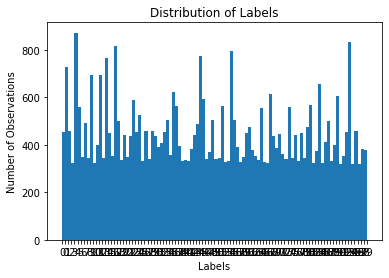

In [ ]:
counts, bins, patches = plt.hist(labels_distrib, bins = 100)

# Set x-axis label
plt.xlabel('Labels')
plt.xticks(bins, bins.astype(int))
# Set y-axis label
plt.ylabel('Number of Observations')

# Set plot title
plt.title('Distribution of Labels')  

## Train on the remaining data 

In [ ]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)
     

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )
     

In [ ]:
model = train_model(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    loaders[0]["train"], 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 1407/1407 [04:26<00:00,  5.29it/s]


Loss: 72.5423 Acc: 13.7484

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 45.0769 Acc: 19.0071

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 36.1820 Acc: 20.9026

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.47it/s]


Loss: 29.3312 Acc: 22.5622

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 23.8855 Acc: 24.1471

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.49it/s]


Loss: 19.0713 Acc: 25.5572

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.50it/s]


Loss: 15.4470 Acc: 26.7960

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.51it/s]


Loss: 8.7784 Acc: 29.4200

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 6.8999 Acc: 30.1770

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.50it/s]

Loss: 5.9939 Acc: 30.5394

Training complete in 42m 54s
Best val Acc: 30.539446


## Repeat process for the other iterations

In [ ]:
# because unlike the missing labels example, the iterations are independent from eachother
# We can train all the models at once, than make predictions for all the labels at once
# this makes the things simpler

In [ ]:
# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/noisy_labels/model_it_0.pt')

In [ ]:
for i in range(1,10): 
    model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
    model.classifier[1] = nn.Linear(1280, 100)
    model = model.to(device) 
    model = train_model(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    loaders[i]["train"], 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])
    torch.save(model.state_dict(), f'/gdrive/MyDrive/checkpoints/noisy_labels/model_it_{i}.pt')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.3708 Acc: 0.3042

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.4221 Acc: 0.3113

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.4296 Acc: 0.3149

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.4003 Acc: 0.3369

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.4245 Acc: 0.3028

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.4086 Acc: 0.3220

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.4538 Acc: 0.3298

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.43it/s]


Loss: 150.3897 Acc: 0.3390

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.4531 Acc: 0.3177

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.4248 Acc: 0.3383

Training complete in 43m 0s
Best val Acc: 0.339019
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.5652 Acc: 0.2687

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.49it/s]


Loss: 150.5455 Acc: 0.2694

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.5926 Acc: 0.2608

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.5716 Acc: 0.2580

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.5509 Acc: 0.2523

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.51it/s]


Loss: 150.5032 Acc: 0.2587

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.51it/s]


Loss: 150.5528 Acc: 0.2601

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.5674 Acc: 0.2715

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:15<00:00,  5.51it/s]


Loss: 150.5859 Acc: 0.2694

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.5112 Acc: 0.2559

Training complete in 42m 32s
Best val Acc: 0.271500
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 150.1574 Acc: 0.2992

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 150.2140 Acc: 0.3021

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.2206 Acc: 0.2822

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 150.1759 Acc: 0.2878

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.1663 Acc: 0.2999

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.53it/s]


Loss: 150.2137 Acc: 0.2978

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 150.2461 Acc: 0.2701

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:14<00:00,  5.52it/s]


Loss: 150.1719 Acc: 0.3205

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.45it/s]


Loss: 150.2607 Acc: 0.2857

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.1828 Acc: 0.2935

Training complete in 42m 33s
Best val Acc: 0.320540
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.5430 Acc: 0.3326

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.6434 Acc: 0.3603

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.5310 Acc: 0.3497

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.6065 Acc: 0.3319

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.5749 Acc: 0.3539

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.5546 Acc: 0.3490

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.5303 Acc: 0.3632

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.6104 Acc: 0.3340

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.5767 Acc: 0.3653

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.5474 Acc: 0.3547

Training complete in 42m 58s
Best val Acc: 0.365316
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.45it/s]


Loss: 149.9253 Acc: 0.4030

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 149.8417 Acc: 0.4108

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 149.9271 Acc: 0.4200

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 149.9143 Acc: 0.4335

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 149.9639 Acc: 0.4172

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 149.8806 Acc: 0.4193

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 149.9342 Acc: 0.4151

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 149.9048 Acc: 0.4080

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 149.9162 Acc: 0.3980

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 149.8818 Acc: 0.4271

Training complete in 42m 57s
Best val Acc: 0.433547


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.7060 Acc: 0.3689

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.6360 Acc: 0.3234

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.6773 Acc: 0.3369

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.6889 Acc: 0.3383

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.6507 Acc: 0.3525

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.6708 Acc: 0.3333

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.6872 Acc: 0.3184

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.6516 Acc: 0.3198

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.6673 Acc: 0.3276

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.6903 Acc: 0.3611

Training complete in 42m 51s
Best val Acc: 0.368870
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:16<00:00,  5.48it/s]


Loss: 150.2038 Acc: 0.3362

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.1416 Acc: 0.3326

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.1803 Acc: 0.3362

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.1441 Acc: 0.3170

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.1624 Acc: 0.3227

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.1674 Acc: 0.3291

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.1685 Acc: 0.3468

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.43it/s]


Loss: 150.1829 Acc: 0.3255

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.1622 Acc: 0.3390

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.1886 Acc: 0.3177

Training complete in 43m 9s
Best val Acc: 0.346837
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.8979 Acc: 0.2402

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.9184 Acc: 0.2082

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:19<00:00,  5.42it/s]


Loss: 150.8989 Acc: 0.2701

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.43it/s]


Loss: 150.8834 Acc: 0.2274

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.43it/s]


Loss: 150.8732 Acc: 0.2459

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.8074 Acc: 0.2530

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]


Loss: 150.8743 Acc: 0.2672

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.8564 Acc: 0.2367

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.8534 Acc: 0.2360

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.44it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loss: 150.8483 Acc: 0.2523

Training complete in 43m 8s
Best val Acc: 0.270078
Epoch 0/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.2236 Acc: 0.2345

Epoch 1/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.2041 Acc: 0.2537

Epoch 2/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.2436 Acc: 0.2687

Epoch 3/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.2801 Acc: 0.2495

Epoch 4/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.46it/s]


Loss: 150.2507 Acc: 0.2900

Epoch 5/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.2444 Acc: 0.2509

Epoch 6/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.47it/s]


Loss: 150.1874 Acc: 0.2580

Epoch 7/9
----------


100%|██████████| 1407/1407 [04:18<00:00,  5.45it/s]


Loss: 150.1854 Acc: 0.2786

Epoch 8/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.45it/s]


Loss: 150.2250 Acc: 0.2679

Epoch 9/9
----------


100%|██████████| 1407/1407 [04:17<00:00,  5.45it/s]

Loss: 150.2056 Acc: 0.2694

Training complete in 42m 57s
Best val Acc: 0.289979


Save the labels that will be used for relabling in a file, such that you can leave the training of the model alone, and later when you return, even if the session has finished, you have the models trained and you know which are the images that need new labels. And you can use the checkpoints to predict them

In [ ]:
paths_labeling = {}
for i in tqdm(range(10)):
    paths_labeling[i] = []
    for images, labels, paths in loaders[i]['labeling']:
        paths_labeling[i].append(paths)

100%|██████████| 10/10 [01:23<00:00,  8.37s/it]


In [ ]:
# Save the experiment information to a JSON file
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models.json', 'w') as f:
    json.dump(paths_labeling, f)

## Predict new labels

In [ ]:
# Read the json of the labels that need to be predicted
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models.json', 'r') as f:
    paths_labeling = json.load(f)


In [ ]:
# create new dataset for pseudo-labeling
all_predicted_labels = {}
for iteration, paths in paths_labeling.items(): 
    paths_list = batches_to_list(paths)
    dataset = ImageDataset(paths_list)    
    labeling_loader = DataLoader(dataset, batch_size=1)
    PATH = f'/gdrive/MyDrive/checkpoints/noisy_labels/model_it_{iteration}.pt'
    model = load_model(PATH, 'cuda')
    all_predicted_labels[iteration] = generate_new_labels(model, labeling_loader, 'cuda')  
    # 00:33<00:00, 149.59it/s on standard GPU
    # [00:18<02:44, 27.31it/s] on standard TPU


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 5000/5000 [00:30<00:00, 164.74it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 5000/5000 [00:31<00:00, 157.75it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 5000/5000 [00:30<00:00, 163.49it/s]
Using cache

In [ ]:
# Sanity check
for i in all_predicted_labels.items():
    print(i[1]['path'][0])
    print(i[1]['confidence'][0])
    print(i[1]['label_predicted'][0])
    print(i[1]['existing_label'][0])
    break

('data/task2/images_by_class/3/1383.jpeg',)
0.3645797073841095
19
3


In [ ]:
# Save the new predictions and the old predictions in a file for future 
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_first_iteration.json', 'w') as f:
    json.dump(all_predicted_labels, f)

## Analyze results pseudo-labeling

I have created new predictions for the labels. But I have only 1 label extra label for each prediction. In order to figure out which labels are correct and which ones are not. I want to use the confidence too. Not only rely on more sessions of pseudo-labeling. Because 1 session costs me about 6 hours anyway. Using the confidence for labeling would be to use a rule similar to these ones: If the labels have the same label and there is a high confidence, I will consider the previous label as valid. If the labels are similar and the confidence is very low, I will try to run this label in another session of relabeling. If the label is different but the confidence is very low, it is probably my mistake. But if the label is different and the confidence is very high. I should probably try to create a new label for that image in another session. 

In [11]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_first_iteration.json', 'r') as f:
    all_predicted_labels = json.load(f)

 There are 10 splits of the data, each one has a corresponding key in this dictionary

In [12]:
all_predicted_labels.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [13]:
# Load the predicted labels and confidence scores
iteration = '0'
predictions = pd.DataFrame.from_dict(all_predicted_labels[iteration],orient='index').transpose()
print(predictions)

                                            path confidence existing_label  \
0       [data/task2/images_by_class/3/1383.jpeg]    0.36458              3   
1     [data/task2/images_by_class/76/29313.jpeg]   0.098717             76   
2     [data/task2/images_by_class/30/12277.jpeg]   0.203538             30   
3     [data/task2/images_by_class/59/22781.jpeg]    0.13695             59   
4     [data/task2/images_by_class/88/34072.jpeg]   0.259119             88   
...                                          ...        ...            ...   
4995  [data/task2/images_by_class/56/21497.jpeg]   0.544975             56   
4996  [data/task2/images_by_class/32/12788.jpeg]   0.115707             32   
4997   [data/task2/images_by_class/22/8574.jpeg]   0.101662             22   
4998  [data/task2/images_by_class/38/14964.jpeg]   0.125019             38   
4999  [data/task2/images_by_class/82/48602.jpeg]   0.089067             82   

     label_predicted  
0                 19  
1                

In [14]:
print("How many labels have the same value after relabling ?")
print((predictions['existing_label'] == predictions['label_predicted']).value_counts())

How many labels have the same value after relabling ?
False    4939
True       61
dtype: int64


What is the confidence of those ?
191     1.041596
220     0.176706
226     0.309039
272     1.208265
378     1.241412
          ...   
4771    0.202634
4789    0.619976
4853    0.182252
4931    0.596758
4982    0.264925
Name: confidence, Length: 61, dtype: object


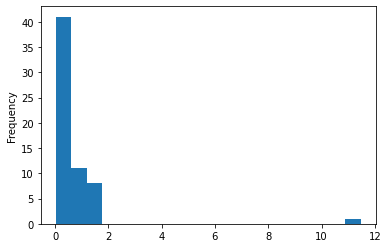

In [15]:
print("What is the confidence of those ?")
print(predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'])
predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

In [16]:
predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.5]
display(predictions_correct_label)

,path,confidence,existing_label,label_predicted
191,[data/task2/images_by_class/19/7468.jpeg],1.041596,19,19
272,[data/task2/images_by_class/30/12107.jpeg],1.208265,30,30
378,[data/task2/images_by_class/34/13499.jpeg],1.241412,34,34
945,[data/task2/images_by_class/92/35180.jpeg],11.464233,92,92
1176,[data/task2/images_by_class/63/23960.jpeg],1.529731,63,63
1253,[data/task2/images_by_class/11/4422.jpeg],1.074163,11,11
1356,[data/task2/images_by_class/34/13544.jpeg],0.647533,34,34
1409,[data/task2/images_by_class/17/42317.jpeg],1.304711,17,17
1506,[data/task2/images_by_class/38/15092.jpeg],0.958325,38,38
1591,[data/task2/images_by_class/19/7451.jpeg],0.862999,19,19


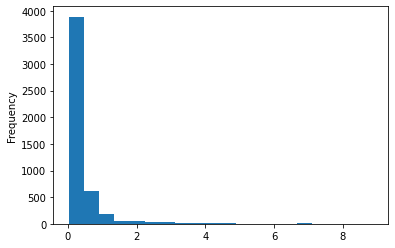

In [17]:
predictions[predictions['existing_label'] != predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

Most of the predictions have very low score, even if they are right or wrong. 
But a very small number of images have a high confidence of being correct or incorrect. 
We would take those images with a very high confidence of being right from each iteration and put them aside as true. Than we will repeat the process of forgetting some images and trying to train on the remaining images. But now we have a little bit better model, since it has some images for which we have a high confidence that they are correct. 

## Repeat thresholding pseudo-labels for the following iterations. 


In [134]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_first_iteration.json', 'r') as f:
    all_predicted_labels = json.load(f)
# Load the predicted labels and confidence scores
correct_labels_df = []
for i in range(10):
    predictions=pd.DataFrame.from_dict(all_predicted_labels[str(i)],orient='index').transpose() 
    predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
    predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.5] 
    correct_labels_df.append(predictions_correct_label)
df_correct = pd.concat(correct_labels_df)

In [135]:
len(df_correct)

431

NOTE: After the first iteration of the algorithm we found 431 images to have correct labels with high confidence. This means we should repeat this process 100 times. Which would take a very large amount of time. But hopefully the futher iterations will become faster as we find that more images are correctly labeled. 

NOTE: Also, because we still have the previous results from the first iteration. If we get the same labels on the second or third iteration, we are much more likely to believe that the respective labels are true, and we can include them in the "pseudo ground truth dataset" even if they don't have a high confidence, but they have the same label on multiple runs. 

NOTE: Finally. In the end we can try again the whole experiment from the beginning. The expectation would be that we would find much fewer wrongly labeled images. 

# Iteration 2
considering previously found labels as true, and not reconsidering to label them anymore. 

In [222]:
target_dir = 'data/task2/images_by_class'

del_dir_if_exist(target_dir)

data/task2/images_by_class has been deleted


In [136]:
# Check if the directory exists, to recreate it instead of messing it up
target_dir = 'data/task2/training_confident'

del_dir_if_exist(target_dir)

data/task2/training_confident does not exist


In [223]:
make_dataset_folder()

100%|██████████| 50000/50000 [00:10<00:00, 4666.24it/s]


In [137]:
# Train on 2 datasets at the same time, one with high confidence labels
# this dataset will only be used during training, never forgetting labels
# the second dataset will iteratively forget labels and train on the remaining labels.
# Define the base directory
target_dir = 'data/task2/training_confident'
# Iterate over the rows in the DataFrame
for _, row in tqdm(df_correct.iterrows(), total=df_correct.shape[0]):
    # Extract the path and class from the row
    path = row['path'][0]
    label = row['existing_label'] 

    # Create the directory for the class
    class_dir = f'{target_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # move the file to the class directory
    shutil.move(f"{path}", class_dir)
    

# we move the images because we don't want them to remain in the dataset for relabeling.  


100%|██████████| 431/431 [00:00<00:00, 7773.98it/s]


In [29]:
# TODO: create the 2 datasets
preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

data_dir_train = 'data/task2/training_confident'
image_dataset_train_only = datasets.ImageFolder(data_dir_train, preprocess) 
dataloader_train_only  = DataLoader(
    image_dataset_train_only, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset_train_only.classes
dataset_size = len(image_dataset_train_only)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [30]:
print(dataset_size)

431


## Create datasets splits for pseudo-labeling round 2

In [ ]:
data_dir = 'data/task2/images_by_class'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)
splits = 2
data_sizes, loaders, device = create_dataset_splits(splits, image_dataset)

In [33]:
print(data_sizes)
print("num samples train", data_sizes['train']*batch_size)

{'train': 775, 'labeling': 775}
num samples train 24800


## Train on remaining data

In [35]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)
     

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


In [36]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )

In [37]:
model = train_model2(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    dataloader_train_only,
                    loaders2[0]["train"], 
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 775/775 [02:21<00:00,  5.46it/s]


Loss: 86.6548 Acc: 11.1110

Epoch 1/9
----------


100%|██████████| 775/775 [02:20<00:00,  5.51it/s]


Loss: 51.9183 Acc: 17.8194

Epoch 2/9
----------


100%|██████████| 775/775 [02:23<00:00,  5.41it/s]


Loss: 39.8597 Acc: 20.5716

Epoch 3/9
----------


100%|██████████| 775/775 [02:18<00:00,  5.59it/s]


Loss: 31.2823 Acc: 22.5729

Epoch 4/9
----------


100%|██████████| 775/775 [02:15<00:00,  5.70it/s]


Loss: 24.2291 Acc: 24.5897

Epoch 5/9
----------


100%|██████████| 775/775 [02:16<00:00,  5.67it/s]


Loss: 18.5088 Acc: 26.2800

Epoch 6/9
----------


100%|██████████| 775/775 [02:15<00:00,  5.71it/s]


Loss: 13.6184 Acc: 27.8787

Epoch 7/9
----------


100%|██████████| 775/775 [02:15<00:00,  5.72it/s]


Loss: 7.1740 Acc: 30.4065

Epoch 8/9
----------


100%|██████████| 775/775 [02:17<00:00,  5.64it/s]


Loss: 5.7742 Acc: 30.9032

Epoch 9/9
----------


100%|██████████| 775/775 [02:15<00:00,  5.73it/s]

Loss: 5.1758 Acc: 31.1458

Training complete in 23m 33s
Best val Acc: 31.145806


In [38]:
# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/noisy_labels/model_2_it_0.pt')

In [39]:
## Repeat for the other half

In [40]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = nn.Linear(1280, 100)
model = model.to(device) 
model = train_model2(model, 
                exp_lr_scheduler, 
                optimizer, 
                criterion,  
                data_sizes["train"], 
                dataloader_train_only,
                loaders2[1]["train"], 
                num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])
torch.save(model.state_dict(), f'/gdrive/MyDrive/checkpoints/noisy_labels/model_2_it_{1}.pt')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch 0/9
----------


100%|██████████| 775/775 [02:15<00:00,  5.71it/s]


Loss: 151.0671 Acc: 0.2813

Epoch 1/9
----------


100%|██████████| 775/775 [02:16<00:00,  5.69it/s]


Loss: 151.0593 Acc: 0.2606

Epoch 2/9
----------


100%|██████████| 775/775 [02:17<00:00,  5.62it/s]


Loss: 151.0380 Acc: 0.2606

Epoch 3/9
----------


100%|██████████| 775/775 [02:26<00:00,  5.31it/s]


Loss: 150.9949 Acc: 0.2839

Epoch 4/9
----------


100%|██████████| 775/775 [02:16<00:00,  5.67it/s]


Loss: 151.0060 Acc: 0.2813

Epoch 5/9
----------


100%|██████████| 775/775 [02:23<00:00,  5.41it/s]


Loss: 151.0038 Acc: 0.2826

Epoch 6/9
----------


100%|██████████| 775/775 [02:20<00:00,  5.52it/s]


Loss: 150.9881 Acc: 0.2710

Epoch 7/9
----------


100%|██████████| 775/775 [02:16<00:00,  5.69it/s]


Loss: 151.0254 Acc: 0.2594

Epoch 8/9
----------


100%|██████████| 775/775 [02:16<00:00,  5.67it/s]


Loss: 151.0795 Acc: 0.2619

Epoch 9/9
----------


100%|██████████| 775/775 [02:20<00:00,  5.50it/s]


Loss: 151.0896 Acc: 0.2865

Training complete in 23m 34s
Best val Acc: 0.286452


## save labels for later predicting

In [44]:
paths_labeling = {}
for i in range(splits):
    paths_labeling[i] = []
    for images, labels, paths in tqdm(loaders2[i]['labeling']):
        paths_labeling[i].append(paths)

100%|██████████| 775/775 [00:38<00:00, 19.96it/s]


In [45]:
# Save the experiment information to a JSON file
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models_2.json', 'w') as f:
    json.dump(paths_labeling, f)

## Predict new labels 2

In [215]:
# Read the json of the labels that need to be predicted
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models_2.json', 'r') as f:
    paths_labeling = json.load(f)

In [224]:
# create new dataset for pseudo-labeling
all_predicted_labels = {}
for iteration, paths in paths_labeling.items(): 
    paths_list = batches_to_list(paths)
    dataset = ImageDataset(paths_list)    
    labeling_loader = DataLoader(dataset, batch_size=1)
    PATH = f'/gdrive/MyDrive/checkpoints/noisy_labels/model_2_it_{iteration}.pt'
    model = load_model(PATH, 'cuda')
    all_predicted_labels[iteration] = generate_new_labels(model, labeling_loader, 'cuda')   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 24784/24784 [02:41<00:00, 153.12it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 24784/24784 [02:41<00:00, 153.32it/s]


In [225]:
# Sanity check
for i in all_predicted_labels.items():
    print(i[1]['path'][0])
    print(i[1]['confidence'][0])
    print(i[1]['label_predicted'][0])
    print(i[1]['existing_label'][0])
    break

('data/task2/images_by_class/81/31055.jpeg',)
0.14650920033454895
90
81


In [226]:
# Save the new predictions and the old predictions in a file for future 
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_second_iteration.json', 'w') as f:
    json.dump(all_predicted_labels, f)

## Analyze pseudo lableing from second iteration

In [57]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_second_iteration.json', 'r') as f:
    all_predicted_labels = json.load(f)

In [58]:
all_predicted_labels.keys()

dict_keys(['0', '1'])

In [59]:
# Load the predicted labels and confidence scores
iteration = '0'
predictions = pd.DataFrame.from_dict(all_predicted_labels[iteration],orient='index').transpose()
print(predictions)

                                             path confidence existing_label  \
0      [data/task2/images_by_class/81/31055.jpeg]    0.03861             81   
1      [data/task2/images_by_class/86/33112.jpeg]   0.122728             86   
2      [data/task2/images_by_class/42/43263.jpeg]   0.151605             42   
3      [data/task2/images_by_class/80/30852.jpeg]   0.188782             80   
4      [data/task2/images_by_class/94/36087.jpeg]   0.088798             94   
...                                           ...        ...            ...   
24779  [data/task2/images_by_class/27/10476.jpeg]    0.05421             27   
24780  [data/task2/images_by_class/69/26650.jpeg]   0.104292             69   
24781  [data/task2/images_by_class/67/25549.jpeg]   0.182475             67   
24782   [data/task2/images_by_class/14/5501.jpeg]   0.504089             14   
24783    [data/task2/images_by_class/5/2113.jpeg]   2.366076              5   

      label_predicted  
0                  85  
1  

In [227]:
print("How many labels have the same value after relabling ?")
print((predictions['existing_label'] == predictions['label_predicted']).value_counts())

How many labels have the same value after relabling ?
False    22782
True       233
dtype: int64


What is the confidence of those ?
69       0.317126
86        0.62353
387      0.211072
620      0.169154
740      0.358847
           ...   
22567    0.059484
22649    0.509168
22691    0.294431
22771    0.052772
22881     0.23819
Name: confidence, Length: 233, dtype: object


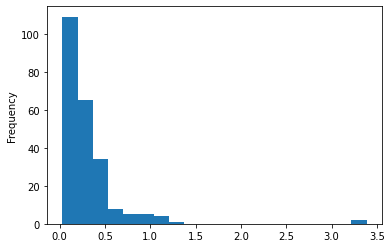

In [228]:
print("What is the confidence of those ?")
print(predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'])
predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

In [230]:
predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.5]
len(predictions_correct_label)

28

the distribution of labels different from one dataset to another


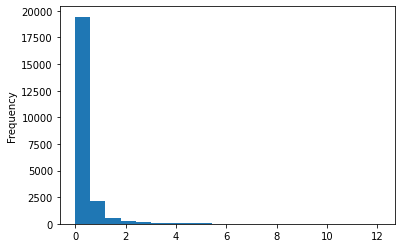

In [231]:
print("the distribution of labels different from one dataset to another")
predictions[predictions['existing_label'] != predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

## Repeat thresholding pseudo-labels for the following iterations.

The second iteration has a different process for analyzing the labels, we are not only interested if the new labels have the the same label as the one provided by the dataset. We are also interested to see if the first iteration gives labels equal to the second iteration. And also how high is the confidence, even if the labels are "wrong" ( different from dataset), but for which both models provide the same label

In [327]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_second_iteration.json', 'r') as f:
    all_predicted_labels2 = json.load(f)
# Load the predicted labels and confidence scores
correct_labels_df = []
for i in range(splits):
    predictions=pd.DataFrame.from_dict(all_predicted_labels2[str(i)],orient='index').transpose() 
    predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
    predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.2] 
    correct_labels_df.append(predictions_correct_label)
df_correct2 = pd.concat(correct_labels_df)
df_correct2['path'] = df_correct2['path'].apply(lambda x: x[0])

In [328]:
len(df_correct2)

389

In [329]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_first_iteration.json', 'r') as f:
    all_predicted_labels1 = json.load(f)
# Load the predicted labels and confidence scores
correct_labels_df_1 = []
for i in range(10):
    predictions=pd.DataFrame.from_dict(all_predicted_labels1[str(i)],orient='index').transpose() 
    predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
    predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.2] 
    correct_labels_df_1.append(predictions_correct_label)

df_correct_1 = pd.concat(correct_labels_df_1)
df_correct_1['path'] = df_correct_1['path'].apply(lambda x: x[0])

In [330]:
df_correct_1

,path,confidence,existing_label,label_predicted
191,data/task2/images_by_class/19/7468.jpeg,1.041596,19,19
226,data/task2/images_by_class/34/13438.jpeg,0.309039,34,34
272,data/task2/images_by_class/30/12107.jpeg,1.208265,30,30
378,data/task2/images_by_class/34/13499.jpeg,1.241412,34,34
945,data/task2/images_by_class/92/35180.jpeg,11.464233,92,92
...,...,...,...,...
4310,data/task2/images_by_class/50/19476.jpeg,1.982109,50,50
4365,data/task2/images_by_class/52/19993.jpeg,2.803925,52,52
4545,data/task2/images_by_class/38/48931.jpeg,3.05493,38,38
4587,data/task2/images_by_class/38/15138.jpeg,1.706635,38,38


In [331]:
df_correct2

,path,confidence,existing_label,label_predicted
17,data/task2/images_by_class/38/15011.jpeg,0.28361,38,38
169,data/task2/images_by_class/61/23360.jpeg,0.201992,61,61
348,data/task2/images_by_class/44/17304.jpeg,2.34158,44,44
672,data/task2/images_by_class/38/46636.jpeg,2.110656,38,38
781,data/task2/images_by_class/33/13269.jpeg,0.464516,33,33
...,...,...,...,...
24508,data/task2/images_by_class/47/39905.jpeg,1.529039,47,47
24532,data/task2/images_by_class/29/11629.jpeg,2.1298,29,29
24535,data/task2/images_by_class/28/10980.jpeg,0.967887,28,28
24556,data/task2/images_by_class/40/15672.jpeg,2.46378,40,40


In [340]:
df_all1 = prep_to_merge(all_predicted_labels1, 10)
df_all2 = prep_to_merge(all_predicted_labels2, 2)

df_all2.rename({"confidence":"confidence2", "label_predicted":"label_predicted2"}, inplace=True, axis = 1)
df_all2.drop("existing_label", inplace=True,axis=1)
merge_df = pd.merge(df_all1, df_all2, on="path", how="left")
# we don't have all rows for confidence 2 so we use "left" merging

In [333]:
merge_df

,path,confidence,existing_label,label_predicted,confidence2,label_predicted2
0,data/task2/images_by_class/3/1383.jpeg,0.36458,3,19,0.916443,69
1,data/task2/images_by_class/76/29313.jpeg,0.098717,76,59,1.734477,47
2,data/task2/images_by_class/30/12277.jpeg,0.203538,30,34,0.174259,44
3,data/task2/images_by_class/59/22781.jpeg,0.13695,59,61,1.593244,17
4,data/task2/images_by_class/88/34072.jpeg,0.259119,88,34,1.78167,3
...,...,...,...,...,...,...
49995,data/task2/images_by_class/74/28286.jpeg,1.359533,74,50,0.029493,17
49996,data/task2/images_by_class/15/45448.jpeg,3.355858,15,61,3.662585,47
49997,data/task2/images_by_class/8/44196.jpeg,1.073675,8,0,0.305969,38
49998,data/task2/images_by_class/75/28828.jpeg,1.837749,75,39,1.070897,99


In [279]:
print("How many rows have the label_predicted2 = label_predicted 2")
print((merge_df['label_predicted'] == merge_df['label_predicted2']).value_counts())

How many rows have the label_predicted2 = label_predicted 2
False    49251
True       749
dtype: int64


**Wow!** There are much more labels that have the same label prediction from 2 models compared to label predictions from only 1 model and the dataset. We can consider them also as correct and try again the process of training. 

What is the confidence distribution of those with same label


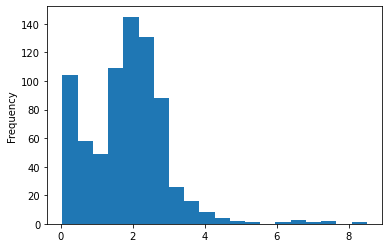

In [280]:
print("What is the confidence distribution of those with same label")
merge_df[merge_df['label_predicted2'] == merge_df['label_predicted']]['confidence'].plot.hist(bins = 20)

We can also notice that the confidence is very similar


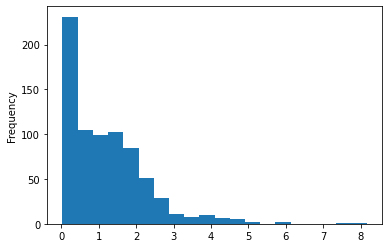

In [281]:
print("We can also notice that the confidence is very similar")
merge_df[merge_df['label_predicted2'] == merge_df['label_predicted']]['confidence2'].plot.hist(bins = 20)

In [282]:
merge_same_label = merge_df[merge_df['label_predicted2'] == merge_df['label_predicted']]
df_merge_correct = merge_same_label[merge_same_label['confidence']>0.2][merge_same_label['confidence2']>0.2]
display(df_merge_correct)

<ipython-input-282-8bc119427798>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merge_correct = merge_same_label[merge_same_label['confidence']>0.2][merge_same_label['confidence2']>0.2]


,path,confidence,existing_label,label_predicted,confidence2,label_predicted2
80,data/task2/images_by_class/63/24071.jpeg,0.218912,63,38,0.617343,38
83,data/task2/images_by_class/6/2774.jpeg,6.238861,6,19,0.323555,19
103,data/task2/images_by_class/94/45260.jpeg,0.275159,94,38,4.134336,38
118,data/task2/images_by_class/6/2498.jpeg,6.526378,6,19,2.381141,19
125,data/task2/images_by_class/49/18982.jpeg,0.599729,49,61,0.650636,61
...,...,...,...,...,...,...
49780,data/task2/images_by_class/66/25295.jpeg,3.268991,66,52,1.482898,52
49832,data/task2/images_by_class/46/17926.jpeg,2.829008,46,18,2.943778,18
49838,data/task2/images_by_class/2/40844.jpeg,3.427066,2,38,4.55372,38
49973,data/task2/images_by_class/73/48233.jpeg,2.605259,73,38,2.49691,38


# Iteration 3

In [283]:
correct_df_all = pd.concat([
    df_merge_correct[['path','existing_label']], 
    df_correct_1[['path','existing_label']], 
    df_correct2[['path','existing_label']]])

In [291]:
correct_df_all = correct_df_all.drop_duplicates()

In [293]:
target_dir = 'data/task2/images_by_class'
del_dir_if_exist(target_dir)

target_dir = 'data/task2/training_confident'
del_dir_if_exist(target_dir)
make_dataset_folder()

data/task2/images_by_class has been deleted
data/task2/training_confident has been deleted


100%|██████████| 50000/50000 [00:13<00:00, 3682.64it/s]


In [294]:
target_dir = 'data/task2/training_confident'
# Iterate over the rows in the DataFrame
for _, row in tqdm(correct_df_all.iterrows(), total=correct_df_all.shape[0]):
    # Extract the path and class from the row
    path = row['path']
    label = row['existing_label'] 

    # Create the directory for the class
    class_dir = f'{target_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # move the file to the class directory
    shutil.move(f"{path}", class_dir)
    

# we move the images because we don't want them to remain in the dataset for relabeling.  

100%|██████████| 1430/1430 [00:00<00:00, 8199.75it/s]


In [295]:
data_dir_train = 'data/task2/training_confident'
image_dataset_train_only = datasets.ImageFolder(data_dir_train, preprocess) 
dataloader_train_only  = DataLoader(
    image_dataset_train_only, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset_train_only.classes
dataset_size = len(image_dataset_train_only)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [296]:
print(dataset_size)

1430


In [297]:
# Move all images considered correct into the training folder

## Create datasets splits 

In [298]:
data_dir = 'data/task2/images_by_class'
image_dataset_unshuffled = datasets.ImageFolder(data_dir, preprocess)
image_dataset = ShuffledImageFolder(image_dataset_unshuffled)
splits = 2
data_sizes, loaders3, device = create_dataset_splits(splits, image_dataset)

In [299]:
batch_size = experiment_info["hyperparameters_data"]["batch_size"]
print(data_sizes)
print("num samples train", data_sizes['train']*batch_size)

{'train': 759, 'labeling': 759}
num samples train 24288


## Train on remaining data

In [300]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [301]:
criterion, optimizer, exp_lr_scheduler = get_training_parameters()

In [302]:
model = train_model2(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    dataloader_train_only,
                    loaders3[0]["train"], 
                    num_epochs=6,
                    # num_epochs=experiment_info["hyperparameters_training"]["num_epochs"]
                     )

Epoch 0/5
----------


  0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
100%|██████████| 759/759 [02:14<00:00,  5.63it/s]


Loss: 82.7125 Acc: 11.7022

Epoch 1/5
----------


100%|██████████| 759/759 [02:12<00:00,  5.73it/s]


Loss: 50.9674 Acc: 17.8880

Epoch 2/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.69it/s]


Loss: 38.9500 Acc: 20.4980

Epoch 3/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.68it/s]


Loss: 30.0343 Acc: 22.7958

Epoch 4/5
----------


100%|██████████| 759/759 [02:12<00:00,  5.73it/s]


Loss: 23.0908 Acc: 24.7312

Epoch 5/5
----------


100%|██████████| 759/759 [02:12<00:00,  5.71it/s]


Loss: 17.2806 Acc: 26.5441

Training complete in 14m 0s
Best val Acc: 26.544137


In [303]:
# Save the model
torch.save(model.state_dict(), '/gdrive/MyDrive/checkpoints/noisy_labels/model_3_it_0.pt')

In [304]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
model.classifier[1] = nn.Linear(1280, 100)
model = model.to(device) 
model = train_model2(model, 
                exp_lr_scheduler, 
                optimizer, 
                criterion,  
                data_sizes["train"], 
                dataloader_train_only,
                loaders3[1]["train"], 
                num_epochs=6,
                # num_epochs=experiment_info["hyperparameters_training"]["num_epochs"]
                )

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.67it/s]


Loss: 150.8961 Acc: 0.3373

Epoch 1/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.68it/s]


Loss: 150.8591 Acc: 0.3478

Epoch 2/5
----------


100%|██████████| 759/759 [02:12<00:00,  5.72it/s]


Loss: 150.9236 Acc: 0.3452

Epoch 3/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.67it/s]


Loss: 150.8933 Acc: 0.3636

Epoch 4/5
----------


100%|██████████| 759/759 [02:13<00:00,  5.69it/s]


Loss: 150.9341 Acc: 0.3531

Epoch 5/5
----------


100%|██████████| 759/759 [02:12<00:00,  5.72it/s]

Loss: 150.9186 Acc: 0.3333

Training complete in 13m 60s
Best val Acc: 0.363636


In [305]:
torch.save(model.state_dict(), f'/gdrive/MyDrive/checkpoints/noisy_labels/model_3_it_{1}.pt')

## save labels for later predicting

In [306]:
paths_labeling = {}
for i in range(splits):
    paths_labeling[i] = []
    for images, labels, paths in tqdm(loaders3[i]['labeling']):
        paths_labeling[i].append(paths)

100%|██████████| 759/759 [00:38<00:00, 19.79it/s]


In [307]:

# Save the experiment information to a JSON file
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models_3.json', 'w') as f:
    json.dump(paths_labeling, f)

## Predict new labels 3

In [308]:
# Read the json of the labels that need to be predicted
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_images_for_models_3.json', 'r') as f:
    paths_labeling = json.load(f)

In [309]:
# create new dataset for pseudo-labeling
all_predicted_labels = {}
for iteration, paths in paths_labeling.items(): 
    paths_list = batches_to_list(paths)
    dataset = ImageDataset(paths_list)    
    labeling_loader = DataLoader(dataset, batch_size=1)
    PATH = f'/gdrive/MyDrive/checkpoints/noisy_labels/model_3_it_{iteration}.pt'
    model = load_model(PATH, 'cuda')
    all_predicted_labels[iteration] = generate_new_labels(model, labeling_loader, 'cuda')   

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 24285/24285 [02:38<00:00, 152.77it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
100%|██████████| 24285/24285 [02:33<00:00, 157.87it/s]


In [310]:
# Save the new predictions and the old predictions in a file for future 
with open(f'/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_third_iteration.json', 'w') as f:
    json.dump(all_predicted_labels, f)

## Analyze pseudo lableing from third iteration

In [313]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_third_iteration.json', 'r') as f:
    all_predicted_labels = json.load(f)

How many labels have the same value after relabling ?
False    23987
True       298
dtype: int64
What is the confidence of those ?
33       0.127792
82       0.431086
120      0.785051
132      0.032602
137      0.704218
           ...   
23652    0.033942
23699    0.414606
23757    0.422824
24099    0.133101
24272    0.086001
Name: confidence, Length: 298, dtype: object


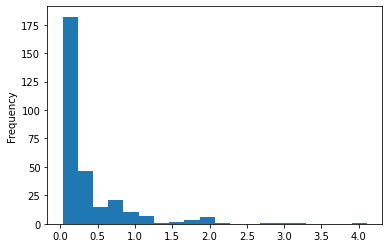

In [312]:
# Load the predicted labels and confidence scores
predictions = pd.DataFrame.from_dict(all_predicted_labels['0'],orient='index').transpose()
print("How many labels have the same value after relabling ?")
print((predictions['existing_label'] == predictions['label_predicted']).value_counts())
print("What is the confidence of those ?")
print(predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'])
predictions[predictions['existing_label'] == predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

How many above threshold?
124
the distribution of labels different from one dataset to another


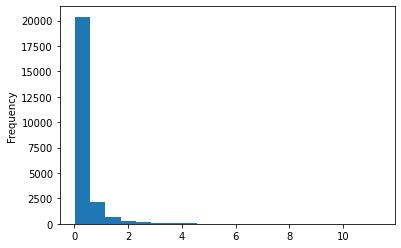

In [315]:
predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.2]
print("How many above threshold?")
print(len(predictions_correct_label))
print("the distribution of labels different from one dataset to another")
predictions[predictions['existing_label'] != predictions['label_predicted']]['confidence'].plot.hist(bins = 20)

In [350]:
with open('/gdrive/MyDrive/checkpoints/noisy_labels/pseudo_labeling_third_iteration.json', 'r') as f:
    all_predicted_labels3 = json.load(f)
# Load the predicted labels and confidence scores
correct_labels_df3 = []
for i in range(splits):
    predictions=pd.DataFrame.from_dict(all_predicted_labels3[str(i)],orient='index').transpose() 
    predictions_same_label = predictions[predictions['existing_label'] == predictions['label_predicted']]
    predictions_correct_label = predictions_same_label[predictions_same_label['confidence']>0.1] 
    correct_labels_df3.append(predictions_correct_label)
df_correct3 = pd.concat(correct_labels_df3)
df_correct3['path'] = df_correct3['path'].apply(lambda x: x[0])

In [351]:
len(df_correct3)

450

In [352]:
df_all3 = prep_to_merge(all_predicted_labels3, 2)

In [353]:
df_all3.rename({"confidence":"confidence3", "label_predicted":"label_predicted3"}, inplace=True, axis = 1)
df_all3.drop("existing_label", inplace=True,axis=1)
df_all3

,path,confidence3,label_predicted3
0,data/task2/images_by_class/4/45175.jpeg,0.162594,34
1,data/task2/images_by_class/62/23557.jpeg,0.041466,2
2,data/task2/images_by_class/8/49212.jpeg,0.40802,19
3,data/task2/images_by_class/37/14708.jpeg,0.13028,34
4,data/task2/images_by_class/81/31158.jpeg,0.040965,24
...,...,...,...
24280,data/task2/images_by_class/90/34530.jpeg,1.584019,78
24281,data/task2/images_by_class/36/14287.jpeg,3.317563,5
24282,data/task2/images_by_class/13/5195.jpeg,3.333233,78
24283,data/task2/images_by_class/5/2260.jpeg,0.995843,14


In [358]:
df_all1 = prep_to_merge(all_predicted_labels1, 10)
df_all2 = prep_to_merge(all_predicted_labels2, 2)

df_all2.rename({"confidence":"confidence2", "label_predicted":"label_predicted2"}, inplace=True, axis = 1)
df_all2.drop("existing_label", inplace=True,axis=1)
merge_df = pd.merge(df_all1, df_all2, on="path", how="left")
# we don't have all rows for confidence 2 so we use "left" merging
merge_df = pd.merge(merge_df, df_all3, on="path", how="left")

In [359]:
merge_df

,path,confidence,existing_label,label_predicted,confidence2,label_predicted2,confidence3,label_predicted3
0,data/task2/images_by_class/3/1383.jpeg,0.36458,3,19,0.916443,69,0.991553,19
1,data/task2/images_by_class/76/29313.jpeg,0.098717,76,59,1.734477,47,1.321538,78
2,data/task2/images_by_class/30/12277.jpeg,0.203538,30,34,0.174259,44,0.154604,56
3,data/task2/images_by_class/59/22781.jpeg,0.13695,59,61,1.593244,17,1.353579,9
4,data/task2/images_by_class/88/34072.jpeg,0.259119,88,34,1.78167,3,2.434512,78
...,...,...,...,...,...,...,...,...
49995,data/task2/images_by_class/74/28286.jpeg,1.359533,74,50,0.029493,17,1.693614,78
49996,data/task2/images_by_class/15/45448.jpeg,3.355858,15,61,3.662585,47,0.348328,56
49997,data/task2/images_by_class/8/44196.jpeg,1.073675,8,0,0.305969,38,1.2268,70
49998,data/task2/images_by_class/75/28828.jpeg,1.837749,75,39,1.070897,99,0.143318,65


In [360]:
print("How many rows have the label_predicted2 = label_predicted 2")
print((merge_df['label_predicted'] == merge_df['label_predicted2']).value_counts())
print((merge_df['label_predicted'] == merge_df['label_predicted3']).value_counts())
print((merge_df['label_predicted3'] == merge_df['label_predicted2']).value_counts())

How many rows have the label_predicted2 = label_predicted 2
False    49251
True       749
dtype: int64
False    49407
True       593
dtype: int64
False    48998
True      1002
dtype: int64


In [362]:
next = merge_df[(merge_df['label_predicted3'] == merge_df['label_predicted2']) +
         (merge_df['label_predicted'] == merge_df['label_predicted2'])
         ]

In [363]:
df_merge_correct = next[next['confidence']>0.1][next['confidence2']>0.1][next['confidence3']>0.1]
display(df_merge_correct)

<ipython-input-363-3e57bbe9fc6c>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_merge_correct = next[next['confidence']>0.1][next['confidence2']>0.1][next['confidence3']>0.1]


,path,confidence,existing_label,label_predicted,confidence2,label_predicted2,confidence3,label_predicted3
133,data/task2/images_by_class/80/30622.jpeg,0.151909,80,77,2.467196,18,1.251756,18
178,data/task2/images_by_class/85/43432.jpeg,1.882455,85,84,1.669616,18,0.996252,18
258,data/task2/images_by_class/41/16197.jpeg,0.313494,41,7,0.859657,19,0.751059,19
303,data/task2/images_by_class/8/3452.jpeg,0.205941,8,30,1.193492,70,1.340853,70
362,data/task2/images_by_class/45/17408.jpeg,0.100038,45,2,0.83005,2,2.378393,78
...,...,...,...,...,...,...,...,...
49908,data/task2/images_by_class/12/47122.jpeg,2.657788,12,98,0.412509,19,0.713494,19
49916,data/task2/images_by_class/10/45198.jpeg,1.309713,10,61,0.985352,19,0.489649,19
49925,data/task2/images_by_class/93/35542.jpeg,2.562606,93,16,3.665642,19,3.110206,19
49963,data/task2/images_by_class/28/11267.jpeg,2.91602,28,67,5.470263,19,1.925581,19


# Evaluation

### Prepare unlabeled dataset

In [156]:
dir_data = 'data/task2/val_data'
# copy data to allow dataloader to read it easier
dest_dir = 'data/task2/val_data/0'
os.makedirs(dest_dir, exist_ok=True)

# Iterate over all the files in the source directory
for file in tqdm(os.listdir(dir_data)):
    if file.endswith(".jpg") or file.endswith(".jpeg") or file.endswith(".png"):
        # Construct the source and destination paths
        src_path = os.path.join(dir_data, file)
        dst_path = os.path.join(dest_dir, file)
        # Move the file
        shutil.move(src_path, dst_path) 

100%|██████████| 5001/5001 [00:00<00:00, 31199.33it/s]


In [173]:
from torchvision.datasets import DatasetFolder


preprocess = transforms.Compose([
    transforms.Resize(experiment_info["image_processing"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=experiment_info["image_processing"]["mean"],
                         std=experiment_info["image_processing"]["std"]),
    ])

dir_data = 'data/task2/val_data'
image_dataset_unlabeled = datasets.ImageFolder(root=dir_data, transform=preprocess)

dataloader_unlabeled  = torch.utils.data.DataLoader(
    image_dataset_unlabeled, 
    batch_size = 1, 
    )

dataset_size = len(image_dataset_unlabeled)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
     

In [171]:
def make_eval_predictions(model, image_dataset_unlabeled, dataloader_unlabeled):
    predicted_labels = {
    "path":[],
    "confidence":[],
    "label":[]
    }

    # Each epoch has a training and validation phase 
    model.eval()   # Set model to evaluate mode 

    # Iterate over data.
    img_path_generator = ((image, path) for (path,_) , (image, _) in zip(image_dataset_unlabeled.samples, dataloader_unlabeled))

    for inputs, path in tqdm(img_path_generator, total=dataset_size):
        inputs = inputs.to(device)

        # forward
        with torch.set_grad_enabled(False): # we don't want to train
            outputs = model(inputs)
            confidence, preds = torch.max(outputs, 1) 
        predicted_labels["path"].append(path) 
        predicted_labels["confidence"].append(confidence.item())
        predicted_labels["label"].append(preds.item())
    return predicted_labels 

### Train a single model on all the correct labels only for evaluation
Also compare this with training on the whole dataset 

In [143]:
target_dir = 'data/task2/images_by_class'
del_dir_if_exist(target_dir)

data/task2/images_by_class has been deleted


In [144]:
# Check if the directory exists, to recreate it instead of messing it up
target_dir = 'data/task2/training_confident'
del_dir_if_exist(target_dir)

data/task2/training_confident has been deleted


In [145]:
make_dataset_folder()

100%|██████████| 50000/50000 [00:10<00:00, 4568.15it/s]


In [147]:
# Train on 2 datasets at the same time, one with high confidence labels
# this dataset will only be used during training, never forgetting labels
# the second dataset will iteratively forget labels and train on the remaining labels.
# Define the base directory
target_dir = 'data/task2/training_confident'
# Iterate over the rows in the DataFrame
for _, row in tqdm(correct_df_all.iterrows(), total=correct_df_all.shape[0]):
    # Extract the path and class from the row
    path = row['path']
    label = row['existing_label'] 

    # Create the directory for the class
    class_dir = f'{target_dir}/{label}'
    os.makedirs(class_dir, exist_ok=True)
    
    # move the file to the class directory
    shutil.move(f"{path}", class_dir)
    

# we move the images because we don't want them to remain in the dataset for relabeling.  


100%|██████████| 3970/3970 [00:01<00:00, 3182.87it/s]


In [255]:
# TODO: create the 2 datasets

data_dir_train = 'data/task2/training_confident'
image_dataset_train_only = datasets.ImageFolder(data_dir_train, preprocess) 
dataloader_train_only  = DataLoader(
    image_dataset_train_only, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset_train_only.classes
dataset_size = len(image_dataset_train_only)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [149]:
print(dataset_size)

3970


In [256]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [257]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(
    model.parameters(),
    lr=experiment_info["hyperparameters_training"]["learning_rate"],
    )

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer, 
    step_size=experiment_info["hyperparameters_training"]["scheduler_step_size"], 
    gamma=experiment_info["hyperparameters_training"]["scheduler_gamma"],
    )

In [258]:
model = train_model3(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    dataloader_train_only,
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.63it/s]


Loss: 6.5748 Acc: 0.2058

Epoch 1/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.65it/s]


Loss: 4.9462 Acc: 0.5072

Epoch 2/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.73it/s]


Loss: 4.0197 Acc: 0.6986

Epoch 3/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Loss: 3.2882 Acc: 0.8545

Epoch 4/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.71it/s]


Loss: 2.6456 Acc: 1.0433

Epoch 5/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.77it/s]


Loss: 2.0811 Acc: 1.2412

Epoch 6/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.80it/s]


Loss: 1.6234 Acc: 1.3735

Epoch 7/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.79it/s]


Loss: 1.2442 Acc: 1.4600

Epoch 8/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.78it/s]


Loss: 1.1899 Acc: 1.4705

Epoch 9/9
----------


100%|██████████| 38/38 [00:05<00:00,  6.83it/s]


Loss: 1.1671 Acc: 1.4862

Training complete in 0m 57s
Best val Acc: 1.486239


In [259]:
path_m = f'/gdrive/MyDrive/checkpoints/noisy_labels/eval_model2.pt'
torch.save(model.state_dict(), path_m)

In [260]:
predicted_labels = make_eval_predictions(model, image_dataset_unlabeled, dataloader_unlabeled)

5000it [00:44, 113.15it/s]


In [263]:
to_csv(predicted_labels, "eval2.csv")

### Train model directly on all images 

In [162]:
target_dir = 'data/task2/images_by_class'
del_dir_if_exist(target_dir)

data/task2/images_by_class has been deleted


In [163]:
# Check if the directory exists, to recreate it instead of messing it up
target_dir = 'data/task2/training_confident'
del_dir_if_exist(target_dir)

data/task2/training_confident has been deleted


In [164]:
make_dataset_folder()

100%|██████████| 50000/50000 [00:11<00:00, 4461.58it/s]


In [165]:
# TODO: create the 2 datasets

data_dir_train = 'data/task2/images_by_class'
image_dataset_train_only = datasets.ImageFolder(data_dir_train, preprocess) 
dataloader_train_only  = DataLoader(
    image_dataset_train_only, 
    batch_size = experiment_info["hyperparameters_data"]["batch_size"],
    shuffle = experiment_info["hyperparameters_data"]["shuffle_dataloader"], 
    num_workers = experiment_info["hyperparameters_data"]["num_workers"]
    )

class_names = image_dataset_train_only.classes
dataset_size = len(image_dataset_train_only)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [166]:
# Download a pytorch MobileNet pretrained model
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# change the Linear output to fit our dataset ( because model initially has 1000 classes)
model.classifier[1] = nn.Linear(1280, 100)
# Setting hyperparameters

model = model.to(device)
print(model.classifier)

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=100, bias=True)
)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [167]:
model = train_model3(model, 
                    exp_lr_scheduler, 
                    optimizer, 
                    criterion,  
                    data_sizes["train"], 
                    dataloader_train_only,
                    num_epochs=experiment_info["hyperparameters_training"]["num_epochs"])

Epoch 0/9
----------


100%|██████████| 1563/1563 [03:47<00:00,  6.86it/s]


Loss: 301.8403 Acc: 0.7884

Epoch 1/9
----------


100%|██████████| 1563/1563 [03:46<00:00,  6.91it/s]


Loss: 301.8761 Acc: 0.7665

Epoch 2/9
----------


100%|██████████| 1563/1563 [03:36<00:00,  7.22it/s]


Loss: 301.7891 Acc: 0.7600

Epoch 3/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.39it/s]


Loss: 301.8233 Acc: 0.8052

Epoch 4/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.39it/s]


Loss: 301.6771 Acc: 0.7613

Epoch 5/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.37it/s]


Loss: 301.8680 Acc: 0.7316

Epoch 6/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.38it/s]


Loss: 301.7473 Acc: 0.8039

Epoch 7/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.38it/s]


Loss: 301.8817 Acc: 0.7613

Epoch 8/9
----------


100%|██████████| 1563/1563 [03:32<00:00,  7.36it/s]


Loss: 301.7556 Acc: 0.7290

Epoch 9/9
----------


100%|██████████| 1563/1563 [03:31<00:00,  7.39it/s]

Loss: 301.7398 Acc: 0.7561

Training complete in 35m 53s
Best val Acc: 0.805161


In [168]:
path_m = f'/gdrive/MyDrive/checkpoints/noisy_labels/just_train.pt'
torch.save(model.state_dict(), path_m)

In [174]:
predicted_labels = make_eval_predictions(model, image_dataset_unlabeled, dataloader_unlabeled)

100%|██████████| 5000/5000 [00:42<00:00, 116.77it/s]


In [177]:
to_csv(predicted_labels, "just_train.csv")